In [1]:

import ast
import sys
import math


import numpy as np #v 1.23.3
import networkx as nx
import pandas as pd
import os
import re
#os.chdir('/home/ll16598/Documents/ARCHITECTURAL_IMMUNITY/ANALYSIS')
import scipy
import pickle
#import ThreeD_Net_Tools_0203 as D3
from collections import Counter
# In[ ]:
from tqdm import tqdm


In [2]:
  variable_list=['rt',
                    #'rt_centroid', 
                    'density',
                    'edges',
                    'triangle_density', 
                    'tetra_density',
                    'penta', 
                    'nodes',
                    'shortest_path_weighted','shortest_path_unweighted',
                 #  'num_triangles', 'num_tetrahedra',
                    'modularity_louvain', 'modularity_unw','spectral_gap','num_comms_unw','num_comms',
                'clustering_coefficient', 'max_degree',
                    'mean_degree', 'max_betweenness', 'mean_betweenness', 'max_strength',
                    'mean_strength', 
                'fiedler_value', 'largest_laplacian_eigenvalue',
                    'death_rate_dim0', 'mean_persistence_dim0',
                    'max_persistence_dim0', 'std_persistence_dim0', 'skewness_dim0',
                    'kurtosis_dim0', 'entropy_dim0', 'number_dim0',
  'birth_rate_dim1',
  'death_rate_dim1',
  'mean_persistence_dim1', 'max_persistence_dim1',
  'std_persistence_dim1', 'skewness_dim1', 'kurtosis_dim1',
   'entropy_dim1', 'number_dim1']

In [149]:
drug_order=pd.read_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/mono_drug_order.csv')

In [151]:
working_dir='/home/ll16598/Documents/POSTDOC/TDA_output/'
import pandas as pd
import numpy as np
import re
from scipy.special import comb
df_list=[]
# Define parameters

small_talk = True
JUST_SER = False
RANDOM_TASK = True
analysis = 'TDA'  # change as needed; in R, this variable was assumed defined
# In R, window was first set to 80 then overwritten to 'window'
window = "utterances"  # possible values: "window" or "utterances"
overlap = 0.1
POOL_SER = False  # TO POOL THE SER EXPERIMENTAL CONDITIONS
z_normalise = True
dim_reduction = '50'

# Decide which dataframes to process based on flags
if JUST_SER:
    df_names = ["SER_IPSP", "PEM_df"]
elif small_talk:
    df_names = ['SER_monologs', 'SER_IPSP', 'PEM_df', 'MASM', 'cleaned_DEI']
else:
    df_names = ['SER_IPSP', 'SER_monologs', 'PEM_df']

span = 40

# Define helper functions
def z_norm(df, var):
    """Adds 1 to the variable, then calculates a placebo-based z-score."""
    df[var] = df[var] + 1
    # Subset rows where Drug is 'PL' and var is not NA
    df_placebo = df[df['Drug'] == 'PL'].dropna(subset=[var])
    mean_placebo = df_placebo[var].mean()
    std_placebo = df_placebo[var].std()
    df['centered_var'] = df[var] - mean_placebo
    df[var] = df['centered_var'] / std_placebo
    return df

def remove_bracs(df, var):
    """If the column is not numeric, removes brackets and converts to numeric."""
    if not pd.api.types.is_numeric_dtype(df[var]):
        df[var] = pd.to_numeric(df[var].replace(r'[\[\]]', '', regex=True))
    return df

all_meta = []

# Loop over the chosen span (here just one value: 40)
for span in [1]:
    filter_length = 5

    for df_name in df_names:
        print(f"Processing dataframe: {df_name}")

        wind = str(window)
        # Determine the CSV file path based on analysis and window type
        if analysis == 'syntax':
            csv_file = f"{working_dir}{df_name}_syntax_results.csv"
        elif wind == 'utterances':
            csv_file = f"{working_dir}{df_name}_{span}_mean_{dim_reduction}_utterance_{analysis}_results_seed3.csv"
        elif wind == 'window':
            csv_file = f"{working_dir}{df_name}_{span}_mean_{dim_reduction}_window_{analysis}_results.csv"
        else:
            # This branch will be used if window is numeric (e.g. 80) instead of a string.
            step = str(float(window) * overlap)
            csv_file = f"{working_dir}{df_name}_{wind}_{step}_{analysis}_results.csv"

        # Read the CSV file
        df_with_tda = pd.read_csv(csv_file)

        # Fix Drug labels for specific df_names
        if df_name == 'MASM':
            df_with_tda['Drug'] = df_with_tda['condition']
            df_with_tda.loc[df_with_tda['Drug'] == "['PLC']", 'Drug'] = "PL"
            df_with_tda.loc[df_with_tda['Drug'] == "['MDMA']", 'Drug'] = "MDMA"
            df_with_tda.loc[df_with_tda['Drug'] == "['MA']", 'Drug'] = "MA"
        elif df_name == 'cleaned_DEI':
            df_with_tda['Drug'] = df_with_tda['condition']
            df_with_tda.loc[df_with_tda['Drug'] == "['PLC.txt']", 'Drug'] = "PL"
            df_with_tda.loc[df_with_tda['Drug'] == "['MDMA.txt']", 'Drug'] = "MDMA"
            df_with_tda.loc[df_with_tda['Drug'] == "['MA.txt']", 'Drug'] = "MA"
            # Extract only numbers from participant column
            df_with_tda['participant_numbers_only'] = df_with_tda['participant'].apply(
                lambda x: float(re.sub(r'\D+', '', str(x))) if pd.notnull(x) else np.nan
            )
            df_with_tda = df_with_tda[df_with_tda['participant_numbers_only'] < 521]
        elif df_name=='SER_monologs':
            df_with_tda = df_with_tda.drop(columns=['Drug'])
            df_with_tda = pd.merge(df_with_tda, drug_order[['classification', 'Drug']], 
                          on=['classification'], 
                          how='left')

        # If using TDA analysis, compute densities
        if analysis == 'TDA':
            df_with_tda['edge_density'] = df_with_tda['edges'] / comb(df_with_tda['nodes'], 2, exact=False)
            df_with_tda['triangle_density'] = df_with_tda['tris'] / comb(df_with_tda['nodes'], 3, exact=False)
            df_with_tda['tetra_density'] = df_with_tda['tetra'] / comb(df_with_tda['nodes'], 4, exact=False)

        print(f"Rows before length filtering: {len(df_with_tda)}")
        # Filter rows based on the length criteria
        df_with_tda = df_with_tda[df_with_tda['length'] >= filter_length]
        print('NOT FILTERING LENGTH')
        for initial_var in variable_list:
            df_with_tda = z_norm(df_with_tda, initial_var)
        # Convert numeric 0.00 in Drug column to "PL"
        df_with_tda.loc[df_with_tda['Drug'] == 0.00, 'Drug'] = "PL"
        df_with_tda.loc[df_with_tda['Drug'] == 1.5, 'Drug'] = "MDMA"
        if POOL_SER:
            df_with_tda.loc[df_with_tda['Drug'] == 0.75, 'Drug'] = "1.5"

        df_with_tda['Drug'] = df_with_tda['Drug'].astype('category')
        # Subset the data to the relevant experimental group
        if df_name in ["PEM_df", "MASM", "cleaned_DEI"]:
            exp_group = "MDMA"
            df_sub = df_with_tda[df_with_tda['Drug'].isin(["PL", "MDMA"])]
        else:
            exp_group = "1.5"
            print(list(set(df_with_tda.Drug)))

            df_sub = df_with_tda[df_with_tda['Drug'].isin(["PL", 'MDMA'])]
            
            print(list(set(df_sub.Drug)))

        df_sub['data_name']=df_name
        df_list.append(df_sub)

Processing dataframe: SER_monologs
Rows before length filtering: 104
NOT FILTERING LENGTH
[nan, 0.75, 'PL', 'MDMA']
['PL', 'MDMA']
Processing dataframe: SER_IPSP
Rows before length filtering: 107
NOT FILTERING LENGTH
[0.75, 'PL', 'MDMA']
['PL', 'MDMA']
Processing dataframe: PEM_df
Rows before length filtering: 130
NOT FILTERING LENGTH
Processing dataframe: MASM
Rows before length filtering: 66
NOT FILTERING LENGTH
Processing dataframe: cleaned_DEI
Rows before length filtering: 32
NOT FILTERING LENGTH


/tmp/ipykernel_18255/3721607903.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['data_name']=df_name
/tmp/ipykernel_18255/3721607903.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['data_name']=df_name
/tmp/ipykernel_18255/3721607903.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [152]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [153]:
dfs=pd.concat(df_list,axis=0).reset_index(drop=True)
df_names = ['SER_monologs', 'SER_IPSP', 'PEM_df', 'MASM', 'cleaned_DEI']

dats_to_test=['SER_monologs', 'SER_IPSP', 'PEM_df']
dfs_to_test=dfs[dfs['data_name'].isin(df_names)]

In [154]:
  variable_list=['shortest_path_weighted','shortest_path_unweighted',
 
                'fiedler_value', 'largest_laplacian_eigenvalue',
                    'death_rate_dim0', 'number_dim0',
  'birth_rate_dim1',
  'death_rate_dim1']

In [155]:
dfs_to_test=dfs[dfs['data_name'].isin(dats_to_test)]

In [156]:

# Ensure there are no missing values for your features or target
dfs_to_test = dfs_to_test.dropna(subset=variable_list + ['Drug'])

# Split data into features and target variable
X = dfs_to_test[variable_list]
y = dfs_to_test['Drug']

# Encode target variable if not already numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, examine feature importances
feature_importance = pd.DataFrame({'feature': variable_list, 
                                   'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance)

# Optionally, perform cross-validation
cv_scores = cross_val_score(rf, X, y, cv=10)
print("\nCross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Accuracy: 0.5769230769230769

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.50      0.45      0.48        11

    accuracy                           0.58        26
   macro avg       0.56      0.56      0.56        26
weighted avg       0.57      0.58      0.57        26


Confusion Matrix:
[[10  5]
 [ 6  5]]

Feature Importances:
                        feature  importance
2                 fiedler_value    0.170604
0        shortest_path_weighted    0.165534
7               death_rate_dim1    0.155004
4               death_rate_dim0    0.134434
3  largest_laplacian_eigenvalue    0.127236
6               birth_rate_dim1    0.113028
5                   number_dim0    0.109308
1      shortest_path_unweighted    0.024852

Cross-validation scores: [0.46153846 0.53846154 0.53846154 0.53846154 0.69230769 0.69230769
 0.69230769 0.61538462 0.76923077 0.33333333]
Mean CV Accuracy: 0.58717

In [157]:
  variable_list=['rt',
                    #'rt_centroid', 
                    'density',
                    'edges',
                    'triangle_density', 
                    'tetra_density',
                    'penta', 
                    'nodes',
                    'shortest_path_weighted','shortest_path_unweighted',
                 #  'num_triangles', 'num_tetrahedra',
                    'modularity_louvain', 'modularity_unw','spectral_gap','num_comms_unw','num_comms',
                'clustering_coefficient', 'max_degree',
                    'mean_degree', 'max_betweenness', 'mean_betweenness', 'max_strength',
                    'mean_strength', 
                'fiedler_value', 'largest_laplacian_eigenvalue',
                    'death_rate_dim0', 'mean_persistence_dim0',
                    'max_persistence_dim0', 'std_persistence_dim0', 'skewness_dim0',
                    'kurtosis_dim0', 'entropy_dim0', 'number_dim0',
  'birth_rate_dim1',
  'death_rate_dim1',
  'mean_persistence_dim1', 'max_persistence_dim1',
  'std_persistence_dim1', 'skewness_dim1', 'kurtosis_dim1',
   'entropy_dim1', 'number_dim1']

In [158]:
  variable_list=['shortest_path_weighted',
                    'mean_persistence_dim0', 
  'birth_rate_dim1',
  'death_rate_dim1']

In [159]:
df_names = ['SER_monologs', 'SER_IPSP', 'PEM_df', 'MASM', 'cleaned_DEI']

dats_to_test1=['SER_monologs', 'SER_IPSP', 'PEM_df']
dats_to_test2=['MASM', 'cleaned_DEI']


In [160]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

best_models=[]
Xs=[]
performances=[]
for dats_to_test in [dats_to_test1,dats_to_test2]:
    dfs_to_test=dfs[dfs['data_name'].isin(dats_to_test)]
    # Prepare data (assuming dfs_to_test and variable_list are defined)
    dfs_to_test = dfs_to_test.dropna(subset=variable_list + ['Drug'])
    X = dfs_to_test[variable_list]
    y = dfs_to_test['Drug']
    Xs.append(X)
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Define the XGBoost classifier
    xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='mlogloss')

    # Define a grid of hyperparameters to search
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=xgb,
                               param_grid=param_grid,
                               scoring='f1',
                               cv=10,
                               n_jobs=-1)

    # Run the grid search
    grid_search.fit(X, y)

    print("Best parameters found:", grid_search.best_params_)
    print("Best cross-validation F1 score:", grid_search.best_score_)
    performances.append(grid_search.best_score_)
    best_model = grid_search.best_estimator_
    best_models.append(best_model)


Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}
Best cross-validation F1 score: 0.6593156843156842
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Best cross-validation F1 score: 0.7329365079365079


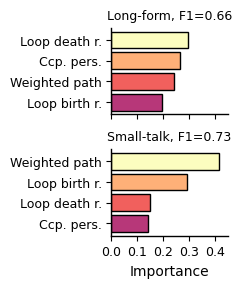

In [161]:
import matplotlib.pyplot as plt
import numpy as np
dir_save_figs='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/plots/'
save=True
titlesize = 10
labsize = 9
lineweight = 1
model_names = ['Long-form', 'Small-talk']
labels = ['Weighted path', 'Ccp. pers.', 'Loop birth r.', 'Loop death r.']

# Determine a global maximum importance to set x ticks
max_importance = max(bm.feature_importances_.max() for bm in best_models)
# Round up to the nearest multiple of 0.05 for the x-axis maximum
xmax = np.ceil(max_importance / 0.05) * 0.05
xticks = np.arange(0, xmax + 0.05, 0.1)

# Create a figure with 2 rows of subplots, sharing the x-axis.
fig, axes = plt.subplots(nrows=2, figsize=(1.5, 2.7), sharex=True)

for idx, (bm, ax) in enumerate(zip(best_models, axes)):
    # Extract feature importances and feature names from the DataFrame
    importances = bm.feature_importances_
    features = Xs[idx].columns  # Assumes each Xs[idx] is a DataFrame with feature names
    # Get sorted indices (from lowest to highest importance)
    indices = np.argsort(importances)
    
    # Use the top half of the magma colormap (values 0.5 to 1.0)
    cmap = plt.get_cmap('magma')
    n = len(indices)
    colors = [cmap(0.5 + 0.5 * (i / (n - 1))) if n > 1 else cmap(1.0) for i in range(n)]
    
    # Plot horizontal bar chart with custom colors and bar edge properties
    ax.barh(range(len(indices)), importances[indices], align='center',
            color=colors, edgecolor='black', linewidth=lineweight)
    ax.set_yticks(range(len(indices)))
    # Use custom y labels based on sorted order
    ax.set_yticklabels([labels[i] for i in indices], fontsize=labsize)
    
    # Set x-axis label only on the bottom subplot
    if idx == 1:
        ax.set_xlabel("Importance", fontsize=titlesize)
    ax.set_title(f"{model_names[idx]}, F1={performances[idx]:.2f}", fontsize=labsize)
    
    # Set consistent x-axis limits and ticks at 0.05 intervals
    ax.set_xlim(0, xmax)
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', labelsize=labsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Set the line thickness of the axes spines
    for spine in ax.spines.values():
        spine.set_linewidth(lineweight)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

if save:
    plt.savefig(dir_save_figs+'Meta_classifier.png', dpi=800, bbox_inches='tight')

#plt.tight_layout()
plt.show()


In [162]:
drug_order=pd.read_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/Drug order.csv')
drug_order['Participant']=drug_order['Subject'].str[-3:]
drug_order['Participant']=drug_order['Participant'].astype(int)

In [138]:
import pandas as pd
import numpy as np

# Define working directory, variable list, and spans
working_dir = '/mnt/onetouch/TDA/TDA_output/'
variable_list = [
    'modularity_louvain',
    'num_comms',
    'density',
    'fiedler_value',
    'spectral_gap',
    'largest_laplacian_eigenvalue',
    'clustering_coefficient',
 #   'mean_strength',
    'mean_persistence_dim0',
    'mean_degree',
#    'max_degree',
   # 'max_strength'
]
spans = [60, 40, 20]

def z_norm(df, var):
    # Add 1 to avoid zero issues (if needed)
    df[var] = df[var] + 1

    # Compute mean and std for placebo group (Drug==0.00)
    df_placebo = df[(df['Drug'] == 0.00) & (df[var].notna())]
    mean_placebo = df_placebo[var].mean()
    std_placebo = df_placebo[var].std()
    
    # Compute the z-score for the entire dataframe
    df['z_score'] = (df[var] - mean_placebo) / std_placebo
    return df

# Load one of the CSV files (for example, the first span) to initialize the master DataFrame.
base_csv = f"{working_dir}SER_monologs_{spans[0]}_mean_50_window_TDA_results.csv"
base_df = pd.read_csv(base_csv)
base_df = base_df.drop(columns=['Drug'])
base_df['Session']=list(base_df.Session.str[-1])
base_df['Session']=base_df['Session'].astype(int)
base_df = pd.merge(base_df, drug_order[['Session', 'Participant', 'Drug']], 
              on=['Session', 'Participant'], 
              how='left')
# Initialize master_df with the same index (or you can use a unique identifier column if available)
master_df = pd.DataFrame(index=base_df.index)

# Loop through each span and variable
for span in spans:
    csv_file = f"{working_dir}SER_monologs_{span}_mean_50_window_TDA_results.csv"
    df = pd.read_csv(csv_file)
    
    for var in variable_list:
        # Calculate z-scores for the variable in the current span
        df_z = z_norm(df.copy(), var)
        
        # Build a new column name; here we take the first part of the variable name
        # so that 'modularity_louvain' becomes 'modularity_60', etc.
        col_base = var.split('_')[0]
        new_col_name = f"{var}_{span}"
        
        # Add the computed z-score to the master DataFrame.
        # This assumes the rows are aligned across all CSVs.
        master_df[new_col_name] = df_z['z_score']

# Now master_df has one column per variable per span, e.g., modularity_60, modularity_40, modularity_20, density_60, etc.
print(master_df.head())


   modularity_louvain_60  num_comms_60  density_60  fiedler_value_60  \
0               0.134273      1.144546   -0.871292         -0.696186   
1              -0.525864     -0.035767    0.312124         -0.139503   
2               0.880699      2.324860   -1.502823         -1.081903   
3               0.283621     -0.035767    0.390674         -0.561673   
4               1.195454     -1.216081   -0.762077         -0.853424   

   spectral_gap_60  largest_laplacian_eigenvalue_60  \
0         1.034366                         0.749744   
1         1.169858                         0.991902   
2         0.139866                        -0.118088   
3        -0.925510                        -0.934041   
4        -0.846947                        -0.930169   

   clustering_coefficient_60  mean_persistence_dim0_60  mean_degree_60  \
0                   0.338248                 -1.217713       -0.269482   
1                   0.318728                 -0.475578        0.639593   
2             

In [139]:
len(base_df)

102

In [141]:
len(base_df)

102

In [142]:
master_df['Drug']=base_df['Drug']
master_df_h_l=master_df[master_df['Drug'].isin([0.00,1.5])]

In [143]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Build a list of all feature columns (i.e. all columns except 'Drug')
feature_cols = master_df_h_l.columns.drop('Drug').tolist()

# Drop rows with missing values in the features and Drug column
df_classifier = master_df_h_l.dropna(subset=feature_cols + ['Drug'])

# Define features and target
X = df_classifier[feature_cols]
y = df_classifier['Drug']

# (Optional) Append X to a list if you are combining multiple datasets
Xs = []
Xs.append(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='mlogloss')

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV with 10-fold cross-validation using the f1 score
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=10,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y_encoded)

print("Best parameters found:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best f1 score: 0.5328571428571429


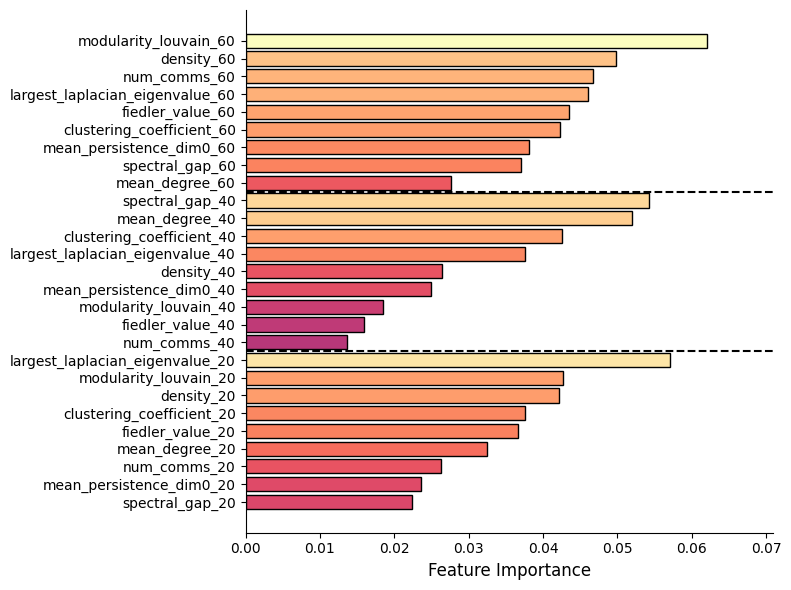

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract feature importances and corresponding feature names
importances = best_model.feature_importances_
features = list(X.columns)
feature_importances = dict(zip(features, importances))

# Define the order in which you want to stratify by span.
# Here, we want all features with '_20' first, then '_40', then '_60'
group_order = ['20', '40', '60']

# For each group, collect features that end with the span identifier,
# sort them by importance (ascending), and keep track of boundaries for plotting.
sorted_features = []
group_boundaries = []
cumulative_count = 0

for span in group_order:
    # Select features that end with the current span (e.g. '_60')
    group_feats = [(f, feature_importances[f]) for f in features if f.endswith(f"_{span}")]
    
    # Sort the features within the group by importance (lowest to highest)
    group_feats_sorted = sorted(group_feats, key=lambda x: x[1])
    
    # Add these sorted features to our master list
    sorted_features.extend(group_feats_sorted)
    
    # Update the cumulative count and record the boundary for this group
    cumulative_count += len(group_feats_sorted)
    group_boundaries.append(cumulative_count)

# Unzip the sorted list into separate lists for names and importances
ordered_features = [f for f, imp in sorted_features]
ordered_importances = [imp for f, imp in sorted_features]

# Compute colors based on feature importance (normalized by actual importance values)
min_imp = min(ordered_importances)
max_imp = max(ordered_importances)
cmap = plt.get_cmap('magma')
colors = []
for imp in ordered_importances:
    # Normalize the importance to [0, 1]
    norm = (imp - min_imp) / (max_imp - min_imp) if max_imp != min_imp else 1.0
    # Map normalized value to a color value between 0.5 and 1.0
    color_val = 0.5 + 0.5 * norm
    colors.append(cmap(color_val))

n = len(ordered_features)
y_pos = np.arange(n)

plt.figure(figsize=(8, 6))
plt.barh(y_pos, ordered_importances, align='center',
         color=colors, edgecolor='black', linewidth=1)
plt.yticks(y_pos, ordered_features, fontsize=10)
plt.xlabel("Feature Importance", fontsize=12)

# Determine x-axis limits (rounding up to the nearest 0.05)
xmax = np.ceil(max(ordered_importances) / 0.05) * 0.05
xticks = np.arange(0, 0.071, 0.01)
plt.xlim(0, 0.071)
plt.xticks(xticks, fontsize=10)

# Draw horizontal dashed lines between strata.
# For each boundary (except the last), draw a line at y = boundary - 0.5.
for boundary in group_boundaries[:-1]:
    plt.axhline(y=boundary - 0.5, color='black', linestyle='--')

# Style adjustments
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


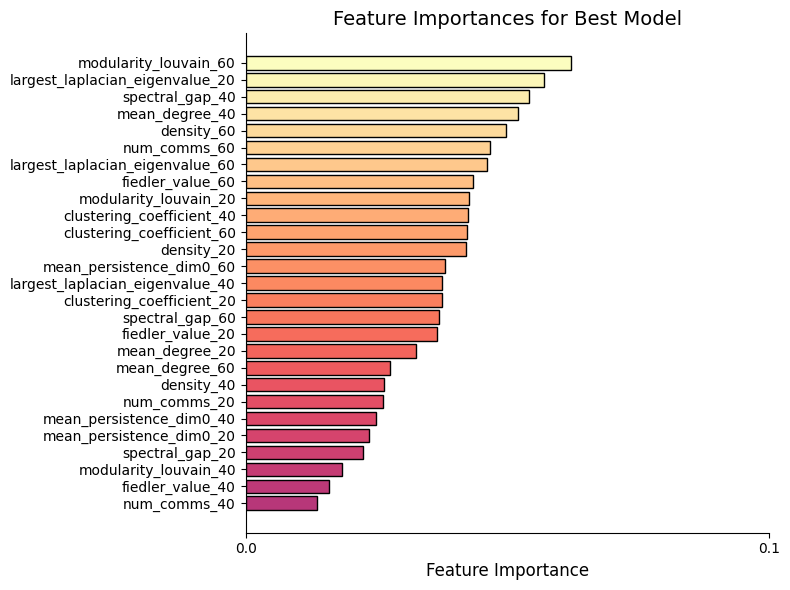

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Extract feature importances and feature names from X (your feature DataFrame)
importances = best_model.feature_importances_
features = X.columns

# Sort the feature importances (smallest to largest)
indices = np.argsort(importances)

# Optional: set up the colormap similar to your previous plots
cmap = plt.get_cmap('magma')
n = len(indices)
colors = [cmap(0.5 + 0.5 * (i / (n - 1))) if n > 1 else cmap(1.0) for i in range(n)]

# Determine x-axis maximum for consistent plotting, rounding up to nearest multiple of 0.05
max_importance = importances.max()
xmax = np.ceil(max_importance / 0.05) * 0.05
xticks = np.arange(0, xmax + 0.05, 0.1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center',
         color=colors, edgecolor='black', linewidth=1)
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=10)
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Feature Importances for Best Model", fontsize=14)
plt.xlim(0, xmax)
plt.xticks(xticks, fontsize=10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Save the figure if desired:
# plt.savefig('/path/to/save/Feature_importances.png', dpi=800, bbox_inches='tight')

plt.show()


In [91]:
def cohen_d(x, y):
    # Calculate the means
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt(((np.std(x, ddof=1) ** 2) + (np.std(y, ddof=1) ** 2)) / 2)
    
    # Calculate Cohen's d
    d = (mean_x - mean_y) / pooled_std
    return d

In [94]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

all_features = master_df_h_l.columns.drop('Drug').tolist()
filtered_features = []

for col in all_features:
    group0 = master_df_h_l.loc[master_df_h_l['Drug'] == 0.00, col]
    group1 = master_df_h_l.loc[master_df_h_l['Drug'] == 1.5, col]
    
    d = cohen_d(group0, group1)
    print(f"Cohen's d for {col}: {d:.3f}")  # Optional: print the value for debugging
    
    if abs(d) > 0.5:
        filtered_features.append(col)

# Now use filtered_features as your feature columns for the classifier
feature_cols = filtered_features
X = master_df_h_l[feature_cols]
y = master_df_h_l['Drug']

# (Optional) Append X to a list if you are combining multiple datasets
Xs = []
Xs.append(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='mlogloss')

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV with 10-fold cross-validation using the f1 score
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=10,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y_encoded)

print("Best parameters found:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)


Cohen's d for modularity_60: -0.705
Cohen's d for num_60: -0.739
Cohen's d for density_60: 0.813
Cohen's d for fiedler_60: 0.540
Cohen's d for spectral_60: -0.266
Cohen's d for largest_60: -0.146
Cohen's d for clustering_60: -0.198
Cohen's d for mean_60: -0.065
Cohen's d for modularity_40: 0.017
Cohen's d for num_40: 0.100
Cohen's d for density_40: -0.174
Cohen's d for fiedler_40: -0.238
Cohen's d for spectral_40: -0.490
Cohen's d for largest_40: -0.492
Cohen's d for clustering_40: -0.588
Cohen's d for mean_40: 0.187
Cohen's d for modularity_20: -0.111
Cohen's d for num_20: 0.031
Cohen's d for density_20: 0.172
Cohen's d for fiedler_20: 0.257
Cohen's d for spectral_20: -0.166
Cohen's d for largest_20: -0.122
Cohen's d for clustering_20: 0.176
Cohen's d for mean_20: -0.131
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best f1 score: 0.6712698412698412


In [120]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing values in the selected features or target
dfs_to_test = dfs_to_test.dropna(subset=variable_list + ['Drug'])

# Define features (X) and target (y)
X = dfs_to_test[variable_list]
y = dfs_to_test['Drug']

# Encode the target variable if it's not already numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Initialize the XGBoost classifier
xgb = XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=True, eval_metric='mlogloss')

# Perform 10-fold cross-validation and compute F1 scores
f1_scores = cross_val_score(xgb, X, y, cv=10, scoring='f1')

print("Cross-validation F1 scores:", f1_scores)
print("Mean CV F1 score:", np.mean(f1_scores))


Cross-validation F1 scores: [0.75       0.57142857 0.         0.75       0.8        0.5
 0.57142857 0.4        0.75       0.8       ]
Mean CV F1 score: 0.5892857142857142


[15:26:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


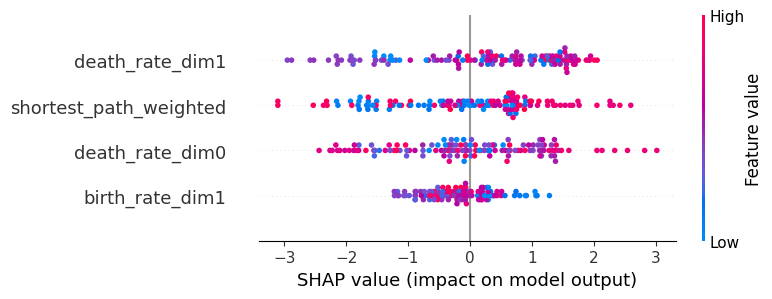

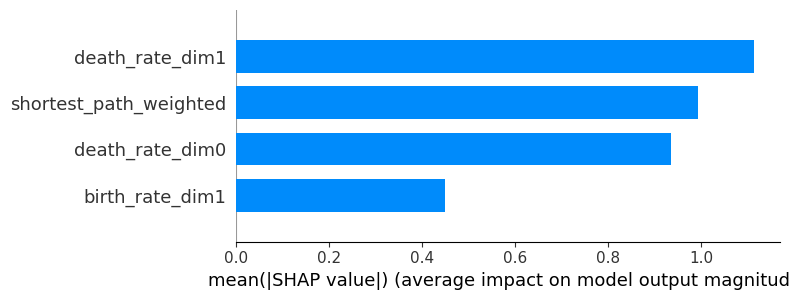

In [115]:
import shap
import matplotlib.pyplot as plt

# Fit the model on the entire dataset (or a representative sample)
xgb.fit(X, y)

# Create a SHAP TreeExplainer object for your trained model
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for your features (X)
shap_values = explainer.shap_values(X)

# Generate a summary plot to visualize the impact of each feature
shap.summary_plot(shap_values, X, feature_names=variable_list)

# Optionally, create a bar plot for mean absolute SHAP values
shap.summary_plot(shap_values, X, feature_names=variable_list, plot_type="bar")


In [209]:
working_dir='/home/ll16598/Documents/POSTDOC/TDA_output/'
import pandas as pd
import numpy as np
import re
from scipy.special import comb
df_list=[]
# Define parameters

small_talk = True
JUST_SER = False
RANDOM_TASK = True
analysis = 'TDA'  # change as needed; in R, this variable was assumed defined
# In R, window was first set to 80 then overwritten to 'window'
window = "utterances"  # possible values: "window" or "utterances"
overlap = 0.1
POOL_SER = False  # TO POOL THE SER EXPERIMENTAL CONDITIONS
z_normalise = True
dim_reduction = '50'

# Decide which dataframes to process based on flags

df_names = ['SER_IPSP','SER1', 'MASM', 'cleaned_DEI']

span = 40

# Define helper functions
def z_norm(df, var):
    """Adds 1 to the variable, then calculates a placebo-based z-score."""
    df[var] = df[var] + 1
    # Subset rows where Drug is 'PL' and var is not NA
    df_placebo = df[df['Drug'] == 'PL'].dropna(subset=[var])
    mean_placebo = df_placebo[var].mean()
    std_placebo = df_placebo[var].std()
    df['centered_var'] = df[var] - mean_placebo
    df[var] = df['centered_var'] / std_placebo
    return df

def remove_bracs(df, var):
    """If the column is not numeric, removes brackets and converts to numeric."""
    if not pd.api.types.is_numeric_dtype(df[var]):
        df[var] = pd.to_numeric(df[var].replace(r'[\[\]]', '', regex=True))
    return df

all_meta = []

# Loop over the chosen span (here just one value: 40)
for span in [1]:
    filter_length = 5

    for df_name in df_names:
        print(f"Processing dataframe: {df_name}")

        wind = str(window)
        # Determine the CSV file path based on analysis and window type
        if analysis == 'syntax':
            csv_file = f"{working_dir}{df_name}_syntax_results.csv"
        elif wind == 'utterances':
            csv_file = f"{working_dir}{df_name}_{span}_mean_{dim_reduction}_utterance_{analysis}_results_seed3.csv"
        elif wind == 'window':
            csv_file = f"{working_dir}{df_name}_{span}_mean_{dim_reduction}_window_{analysis}_results.csv"
        else:
            # This branch will be used if window is numeric (e.g. 80) instead of a string.
            step = str(float(window) * overlap)
            csv_file = f"{working_dir}{df_name}_{wind}_{step}_{analysis}_results.csv"

        # Read the CSV file
        df_with_tda = pd.read_csv(csv_file)

        # Fix Drug labels for specific df_names
        if df_name == 'MASM':
            df_with_tda['Drug'] = df_with_tda['condition']
            df_with_tda.loc[df_with_tda['Drug'] == "['PLC']", 'Drug'] = "PL"
            df_with_tda.loc[df_with_tda['Drug'] == "['MDMA']", 'Drug'] = "MDMA"
            df_with_tda.loc[df_with_tda['Drug'] == "['MA']", 'Drug'] = "MA"
        elif df_name == 'cleaned_DEI':
            df_with_tda['Drug'] = df_with_tda['condition']
            df_with_tda.loc[df_with_tda['Drug'] == "['PLC.txt']", 'Drug'] = "PL"
            df_with_tda.loc[df_with_tda['Drug'] == "['MDMA.txt']", 'Drug'] = "MDMA"
            df_with_tda.loc[df_with_tda['Drug'] == "['MA.txt']", 'Drug'] = "MA"
            # Extract only numbers from participant column
            df_with_tda['participant_numbers_only'] = df_with_tda['participant'].apply(
                lambda x: float(re.sub(r'\D+', '', str(x))) if pd.notnull(x) else np.nan
            )

        # If using TDA analysis, compute densities
        if analysis == 'TDA':
            df_with_tda['edge_density'] = df_with_tda['edges'] / comb(df_with_tda['nodes'], 2, exact=False)
            df_with_tda['triangle_density'] = df_with_tda['tris'] / comb(df_with_tda['nodes'], 3, exact=False)
            df_with_tda['tetra_density'] = df_with_tda['tetra'] / comb(df_with_tda['nodes'], 4, exact=False)

        print(f"Rows before length filtering: {len(df_with_tda)}")
        # Filter rows based on the length criteria
        df_with_tda = df_with_tda[df_with_tda['length'] >= filter_length]
        print('NOT FILTERING LENGTH')
        for initial_var in variable_list:
            df_with_tda = z_norm(df_with_tda, initial_var)
        # Convert numeric 0.00 in Drug column to "PL"
        df_with_tda.loc[df_with_tda['Drug'] == 0.00, 'Drug'] = "PL"
        df_with_tda.loc[df_with_tda['Drug'] == 1.5, 'Drug'] = "MDMA"
        df_with_tda.loc[df_with_tda['Drug'] == '20', 'Drug'] = "MA"
        df_with_tda['Drug'] = df_with_tda['Drug'].astype('category')
        # Subset the data to the relevant experimental group
        if df_name in ["PEM_df", "MASM", "cleaned_DEI"]:
         #   exp_group = "MDMA"
            df_sub = df_with_tda#[df_with_tda['Drug'].isin(["PL", "MDMA"])]
        else:
            df_sub = df_with_tda[df_with_tda['Drug'].isin(["PL", 'MDMA','MA'])]
        df_sub['data_name']=df_name
        df_list.append(df_sub)

Processing dataframe: SER_IPSP
Rows before length filtering: 107
NOT FILTERING LENGTH
Processing dataframe: SER1
Rows before length filtering: 108
NOT FILTERING LENGTH
Processing dataframe: MASM
Rows before length filtering: 66
NOT FILTERING LENGTH
Processing dataframe: cleaned_DEI
Rows before length filtering: 73
NOT FILTERING LENGTH



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [210]:
list(set(dfs_to_test.Drug))

['PL', 'MDMA', 'MA']

In [228]:
dfs=pd.concat(df_list,axis=0).reset_index(drop=True)
df_names = ['SER_monologs', 'SER_IPSP', 'PEM_df', 'MASM', 'cleaned_DEI']
dats_to_test=['SER_IPSP', 'SER1', 'MASM', 'cleaned_DEI']

dats_to_test1=['SER_IPSP', 'SER1']
dats_to_test2=['MASM', 'cleaned_DEI']
dfs_to_test=dfs[dfs['data_name'].isin(dats_to_test2)]

In [229]:
  variable_list=['shortest_path_weighted',
                    'death_rate_dim0', 
  'birth_rate_dim1',
  'death_rate_dim1']

In [230]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Prepare data (assuming dfs_to_test and variable_list are defined)
dfs_to_test = dfs_to_test.dropna(subset=variable_list + ['Drug'])
X = dfs_to_test[variable_list]
y = dfs_to_test['Drug']

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='mlogloss')

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=10,
                           n_jobs=-1)

# Run the grid search
grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)


Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best cross-validation F1 score: 0.4966317016317016


In [136]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

# Use the best estimator from grid search to generate predictions via cross-validation
predictions = cross_val_predict(grid_search.best_estimator_, X, y, cv=10)

# Print the classification report with per-class precision, recall, and F1 scores.
print("Classification Report:")
print(classification_report(y, predictions, target_names=le.classes_))

# Print the confusion matrix to see the distribution of correct and incorrect predictions for each class.
print("Confusion Matrix:")
print(confusion_matrix(y, predictions))


Classification Report:
              precision    recall  f1-score   support

          20       0.64      0.35      0.45        26
          PL       0.57      0.82      0.68        28

    accuracy                           0.59        54
   macro avg       0.61      0.58      0.56        54
weighted avg       0.61      0.59      0.57        54

Confusion Matrix:
[[ 9 17]
 [ 5 23]]
